In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.text import Tokenizer # type: ignore
from tensorflow.keras.preprocessing.sequence import pad_sequences # type: ignore
from tensorflow.keras.models import Model # type: ignore
from tensorflow.keras.layers import Input, LSTM, Dense, Embedding # type: ignore
from tensorflow.keras.optimizers import Adam # type: ignore

In [2]:
data=pd.read_csv("C:\\Users\\DELL\\Desktop\\lang\\eng_-french.csv")

In [3]:
# Add start and end tokens
data['French words/sentences'] = data['French words/sentences'].apply(lambda x: '<start> ' + x + ' <end>')


In [4]:
# Preprocess the data
def preprocess_data(data, num_samples=None):
    data = data.iloc[:num_samples]
    
    # Initialize tokenizers
    eng_tokenizer = Tokenizer(filters='')
    fr_tokenizer = Tokenizer(filters='')
    
    # Manually add start and end tokens
    fr_tokenizer.fit_on_texts(['<start>', '<end>'])
    
    # Fit tokenizers on the actual data
    eng_tokenizer.fit_on_texts(data['English words/sentences'])
    fr_tokenizer.fit_on_texts(data['French words/sentences'])
    
    # Transform text to sequences
    eng_sequences = eng_tokenizer.texts_to_sequences(data['English words/sentences'])
    fr_sequences = fr_tokenizer.texts_to_sequences(data['French words/sentences'])
    
    # Find max length of sequences
    max_eng_length = max(len(seq) for seq in eng_sequences)
    max_fr_length = max(len(seq) for seq in fr_sequences)
    
    # Pad sequences
    eng_sequences = pad_sequences(eng_sequences, maxlen=max_eng_length, padding='post')
    fr_sequences = pad_sequences(fr_sequences, maxlen=max_fr_length, padding='post')
    
    return eng_sequences, fr_sequences, eng_tokenizer, fr_tokenizer, max_eng_length, max_fr_length

eng_sequences, fr_sequences, eng_tokenizer, fr_tokenizer, max_eng_length, max_fr_length = preprocess_data(data)


In [5]:
# Use a smaller subset of data
num_samples = 10000  
eng_sequences, fr_sequences, eng_tokenizer, fr_tokenizer, max_eng_length, max_fr_length = preprocess_data(data, num_samples=num_samples)


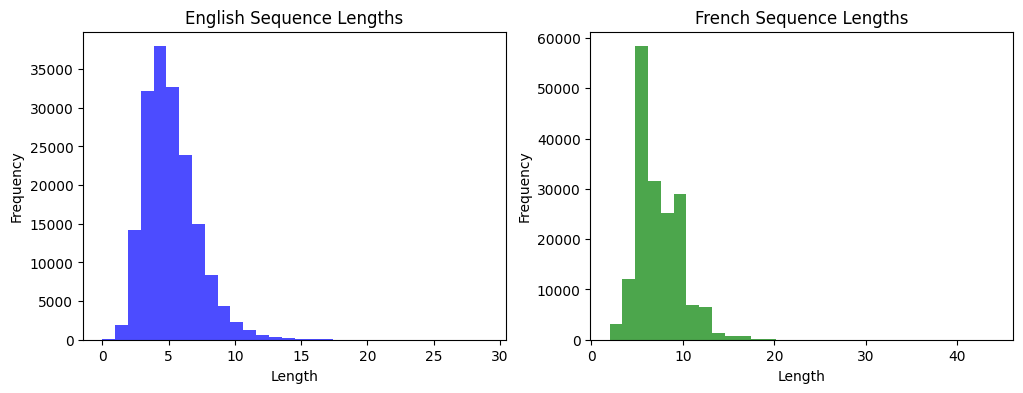

In [6]:
# Plot the distribution of sequence lengths before padding
eng_seq_lengths = [len(seq) for seq in eng_tokenizer.texts_to_sequences(data['English words/sentences'])]
fr_seq_lengths = [len(seq) for seq in fr_tokenizer.texts_to_sequences(data['French words/sentences'])]

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.hist(eng_seq_lengths, bins=30, color='blue', alpha=0.7)
plt.title('English Sequence Lengths')
plt.xlabel('Length')
plt.ylabel('Frequency')

plt.subplot(1, 2, 2)
plt.hist(fr_seq_lengths, bins=30, color='green', alpha=0.7)
plt.title('French Sequence Lengths')
plt.xlabel('Length')
plt.ylabel('Frequency')

plt.show()


In [7]:
# Define the Seq2Seq model using LSTM
def build_seq2seq_model(input_vocab_size, output_vocab_size, input_length, output_length):
    # Encoder
    encoder_inputs = Input(shape=(input_length,))
    encoder_embedding = Embedding(input_dim=input_vocab_size, output_dim=256)(encoder_inputs)
    encoder_lstm = LSTM(256, return_state=True)
    encoder_outputs, state_h, state_c = encoder_lstm(encoder_embedding)
    encoder_states = [state_h, state_c]
    
    # Decoder
    decoder_inputs = Input(shape=(output_length,))
    decoder_embedding = Embedding(input_dim=output_vocab_size, output_dim=256)(decoder_inputs)
    decoder_lstm = LSTM(256, return_sequences=True, return_state=True)
    decoder_outputs, _, _ = decoder_lstm(decoder_embedding, initial_state=encoder_states)
    decoder_dense = Dense(output_vocab_size, activation='softmax')
    decoder_outputs = decoder_dense(decoder_outputs)
    
    # Define the model
    model = Model([encoder_inputs, decoder_inputs], decoder_outputs)
    
    return model

input_vocab_size = len(eng_tokenizer.word_index) + 1
output_vocab_size = len(fr_tokenizer.word_index) + 1

model = build_seq2seq_model(input_vocab_size, output_vocab_size, max_eng_length, max_fr_length)
model.compile(optimizer=Adam(), loss='sparse_categorical_crossentropy', metrics=['accuracy'])


In [8]:
# Prepare the decoder input data
decoder_input_data = np.zeros_like(fr_sequences)
decoder_input_data[:, 1:] = fr_sequences[:, :-1]


In [9]:
# Get the index of the start token
start_token_index = fr_tokenizer.word_index['<start>']
decoder_input_data[:, 0] = start_token_index


In [10]:
# Train the model and capture the history
history = model.fit([eng_sequences, decoder_input_data], np.expand_dims(fr_sequences, -1), epochs=10, batch_size=64, validation_split=0.2)


Epoch 1/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 62s 430ms/step - accuracy: 0.5886 - loss: 4.2420 - val_accuracy: 0.6978 - val_loss: 2.1642
Epoch 2/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 78s 399ms/step - accuracy: 0.7311 - loss: 1.8175 - val_accuracy: 0.7145 - val_loss: 2.0042
Epoch 3/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 47s 375ms/step - accuracy: 0.7442 - loss: 1.6589 - val_accuracy: 0.7188 - val_loss: 1.9356
Epoch 4/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 44s 350ms/step - accuracy: 0.7494 - loss: 1.5652 - val_accuracy: 0.7288 - val_loss: 1.8793
Epoch 5/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 83s 358ms/step - accuracy: 0.7652 - loss: 1.4652 - val_accuracy: 0.7385 - val_loss: 1.8330
Epoch 6/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 43s 343ms/step - accuracy: 0.7762 - loss: 1.3847 - val_accuracy: 0.7410 - val_loss: 1.7981
Epoch 7/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 43s 342ms/step - accuracy: 0.7870 - loss: 1.3005 - val_accuracy: 0.7502 - val_loss: 1.7719
Epoch 8/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 42s 337ms/step - accuracy: 0.7968 - loss: 1

In [11]:
# Evaluate the model
accuracy = model.evaluate([eng_sequences, decoder_input_data], np.expand_dims(fr_sequences, -1), verbose=0)[1]
print(f'Model Accuracy: {accuracy * 100:.2f}%')


Model Accuracy: 80.42%


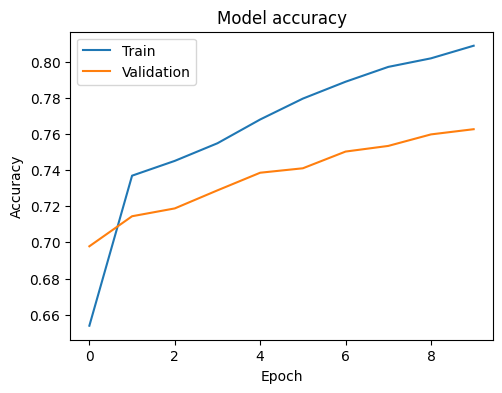

In [12]:
# Plot training & validation accuracy values
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

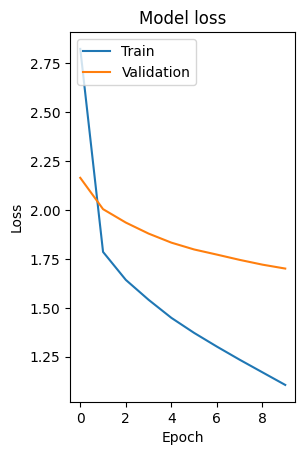

In [13]:
# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.show()


In [14]:
# Function to build inference models
def build_inference_models(input_vocab_size, output_vocab_size, input_length, output_length):
    # Encoder
    encoder_inputs = Input(shape=(input_length,))
    encoder_embedding = Embedding(input_dim=input_vocab_size, output_dim=256)(encoder_inputs)
    encoder_lstm = LSTM(256, return_state=True)
    encoder_outputs, state_h, state_c = encoder_lstm(encoder_embedding)
    encoder_states = [state_h, state_c]
    encoder_model = Model(encoder_inputs, encoder_states)
    
    # Decoder
    decoder_inputs = Input(shape=(1,))
    decoder_embedding = Embedding(input_dim=output_vocab_size, output_dim=256)(decoder_inputs)
    decoder_state_input_h = Input(shape=(256,))
    decoder_state_input_c = Input(shape=(256,))
    decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]
    decoder_lstm = LSTM(256, return_sequences=True, return_state=True)
    decoder_outputs, state_h, state_c = decoder_lstm(decoder_embedding, initial_state=decoder_states_inputs)
    decoder_states = [state_h, state_c]
    decoder_dense = Dense(output_vocab_size, activation='softmax')
    decoder_outputs = decoder_dense(decoder_outputs)
    decoder_model = Model([decoder_inputs] + decoder_states_inputs, [decoder_outputs] + decoder_states)
    
    return encoder_model, decoder_model

encoder_model, decoder_model = build_inference_models(input_vocab_size, output_vocab_size, max_eng_length, max_fr_length)


In [15]:
# Function to translate a given sentence
def translate_sentence(input_sentence):
    input_sequence = eng_tokenizer.texts_to_sequences([input_sentence])
    input_sequence = pad_sequences(input_sequence, maxlen=max_eng_length, padding='post')
    states = encoder_model.predict(input_sequence)
    
    target_seq = np.array([fr_tokenizer.word_index['<start>']])
    stop_condition = False
    decoded_sentence = ''
    
    while not stop_condition:
        output_tokens, h, c = decoder_model.predict([target_seq] + states)
        
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_word = fr_tokenizer.index_word[sampled_token_index]
        decoded_sentence += ' ' + sampled_word
        
        if sampled_word == '<end>' or len(decoded_sentence.split()) > max_fr_length:
            stop_condition = True
        
        target_seq = np.array([sampled_token_index])
        states = [h, c]
    
    return decoded_sentence.replace('<start>', '').replace('<end>', '').strip()

In [18]:
# Test the translation function
test_sentence = "Be nice"
translated_sentence = translate_sentence(test_sentence)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


In [19]:
print(f'Input: {test_sentence}')
print(f'Translated: {translated_sentence}')

Input: Be nice
Translated: casse-toi. mange mange sorti. sorti. conduire ? dehors. dehors. réveillé fleurs. conduire ?
